In [3]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pickle
from scipy.interpolate import griddata
import csv

%run -i storm_coords.py

In [4]:
# Load the contour file
contour_file = 'contour15sp.csv'
df = pd.read_csv( contour_file )
contour15sp = np.column_stack( (df['contour15s_lon'], df['contour15s_lat']) )
normals15sp = np.column_stack( (df['normals15_x'], df['normals15_y']) )
df

,contour15s_lon,contour15s_lat,contour15s_x,contour15s_y,normals15_x,normals15_y
0,-90.294734,28.974981,-407646.233968,3.241079e+06,-0.334033,0.942561
1,-90.276154,28.982270,-405759.053321,3.241748e+06,-0.332962,0.942940
2,-90.257552,28.989520,-403870.358218,3.242413e+06,-0.330494,0.943808
3,-90.238922,28.996719,-401979.704655,3.243071e+06,-0.327351,0.944903
4,-90.220259,29.003855,-400086.628569,3.243723e+06,-0.323481,0.946235
...,...,...,...,...,...,...
645,-81.857377,24.891239,413404.226165,2.753178e+06,0.964150,-0.265357
646,-81.862790,24.873846,412845.273749,2.751255e+06,0.956094,-0.293060
647,-81.868752,24.856604,412230.864626,2.749350e+06,0.947187,-0.320682
648,-81.875258,24.839526,411561.322655,2.747463e+06,0.937470,-0.348066


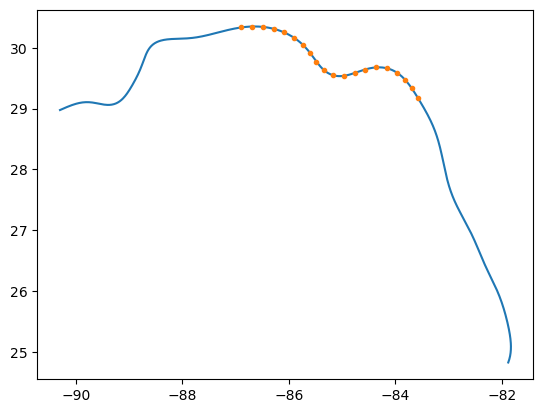

In [5]:
# Get a subset to start with
plt.plot(contour15sp[:,0], contour15sp[:,1])
s,e = 200, 400
plt.plot(contour15sp[s:e:10,0],contour15sp[s:e:10,1],'.')

In [7]:
contour_points = contour15sp[s:e:10,:]
normals = normals15sp[s:e:10,:]
print(len(contour_points))

20


In [8]:
# Read the wave model history file...this has higher density fields for depth and bulk model results
his_url = 'https://geoport.whoi.edu/thredds/dodsC/vortexfs1/usgs/Projects/Helene2024/rehindcast2/Output/coawst_gomsab_his.nc'
ds_his = xr.open_dataset(his_url)
ds_his

OSError: [Errno -70] NetCDF: DAP server error: 'https://geoport.whoi.edu/thredds/dodsC/vortexfs1/usgs/Projects/Helene2024/rehindcast2/Output/coawst_gomsab_his.nc'

In [9]:
his_url = 'https://geoport.whoi.edu/thredds/dodsC/vortexfs1/usgs/Projects/Helene2024/rehindcast2/Output/coawst_gomsab_his.nc'
ds = xr.open_dataset(his_url)

OSError: [Errno -70] NetCDF: DAP server error: 'https://geoport.whoi.edu/thredds/dodsC/vortexfs1/usgs/Projects/Helene2024/rehindcast2/Output/coawst_gomsab_his.nc'

In [14]:
print( ds_his['lat_rho'][0][0].values, ds_his['lat_rho'][0][-1].values )
print( ds_his['lat_rho'][-1][0].values, ds_his['lat_rho'][-1][-1].values )
print( ds_his['lat_rho'][0][0].values, ds_his['lat_rho'][0][832].values )
print( ds_his['lat_rho'][511][0].values, ds_his['lat_rho'][511][832].values )

print( ds_his['lon_rho'][0][0].values, ds_his['lon_rho'][0][-1].values )
print( ds_his['lon_rho'][-1][0].values, ds_his['lon_rho'][-1][-1].values )
print( ds_his['lon_rho'][0][0].values, ds_his['lon_rho'][0][832].values )
print( ds_his['lon_rho'][511][0].values, ds_his['lon_rho'][511][832].values )

20.852134446132126 26.529261583412453
30.34763307220233 35.89691943750916
20.852134446132126 26.529261583412453
30.34763307220233 35.89691943750916
-87.02097037489125 -74.49467236474399
-91.1418732177684 -78.51723615225691
-87.02097037489125 -74.49467236474399
-91.1418732177684 -78.51723615225691


In [ ]:
def haversine(lon1, lat1, lon2, lat2, radius=6371.):
    """
    Calculate the great circle distance between two points
    on the earth. Input in decimal degrees.
    
    All args must be of equal length. 

    https://stackoverflow.com/questions/29545704/fast-haversine-approximation-python-pandas   
    Default radius of earth is  6371 km
    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2  
    c = 2 * np.arcsin(np.sqrt(a))
    km = radius * c
    return km


In [22]:
from scipy.spatial.distance import cdist
from scipy.interpolate import interp2d

for contour_point in contour_points:
    clat, clon = contour_point
    dists = haversine( clon, clat, np.ravel(df_his['lon_rho'].values), np.ravel(df_his['lat_rho'].values))
    

NameError: name 'df_his' is not defined

In [16]:
# I can't remember why I am doing all this
# Extract lat/lon from `ds_his` (h's grid)
lat_his = ds_his['lat_rho'].values  # Shape (512, 833)
lon_his = ds_his['lon_rho'].values  # Shape (512, 833)
depth_h = ds_his['h'].values        # Shape (512, 833)

# Flatten the lat/lon grid for interpolation
lat_his_flat = lat_his.ravel()
lon_his_flat = lon_his.ravel()
depth_h_flat = depth_h.ravel()

# Create meshgrid for the target `ds` lat/lon
lat_ds = ds['lat'].values
lon_ds = ds['lon'].values
lon_mesh, lat_mesh = np.meshgrid(lon_ds, lat_ds)

# Interpolate depth values onto `ds` grid
h_interp = griddata(
    (lon_his_flat, lat_his_flat),  # Source points (flattened lon/lat)
    depth_h_flat,                  # Source values (flattened depth)
    (lon_mesh, lat_mesh),          # Target grid
    method='linear'                # Interpolation method
)

# Extract lat/lon from `ds_his` (h's grid)
lat_his = ds_his['lat_rho'].values  # Shape (512, 833)
lon_his = ds_his['lon_rho'].values  # Shape (512, 833)
depth_h = ds_his['h'].values        # Shape (512, 833)

# Flatten the lat/lon grid for interpolation
lat_his_flat = lat_his.ravel()
lon_his_flat = lon_his.ravel()
depth_h_flat = depth_h.ravel()

# Create meshgrid for the target `ds` lat/lon
lat_ds = ds['lat'].values
lon_ds = ds['lon'].values
lon_mesh, lat_mesh = np.meshgrid(lon_ds, lat_ds)

# Interpolate depth values onto `ds` grid
h_interp = griddata(
    (lon_his_flat, lat_his_flat),  # Source points (flattened lon/lat)
    depth_h_flat,                  # Source values (flattened depth)
    (lon_mesh, lat_mesh),          # Target grid
    method='linear'                # Interpolation method
)

# Convert to xarray.DataArray for consistency
h_da = xr.DataArray(
    h_interp,
    coords={"lat": lat_ds, "lon": lon_ds},
    dims=("lat", "lon"),
    name="water_depth"
)

# Convert to xarray.DataArray for consistency
h_da = xr.DataArray(
    h_interp,
    coords={"lat": lat_ds, "lon": lon_ds},
    dims=("lat", "lon"),
    name="water_depth"
)

# Result is now in `h_da` and can be accessed as a NumPy array or xarray
h_da


<xarray.DataArray 'water_depth' (lat: 71, lon: 40)> Size: 23kB
array([[ 745.32418878,  901.17174429, 1049.16081668, ...,  111.41679675,
          94.75692197,   73.76256225],
       [ 826.34019359, 1001.95262415, 1192.48821586, ...,  396.12191495,
         330.14904006,  241.70188718],
       [ 916.70768801, 1133.39770285, 1447.49560288, ...,  998.46119852,
         860.49089877,  678.43667462],
       ...,
       [ 108.28663679,   92.01269936,   75.83331435, ...,    5.00000001,
           5.        ,    5.        ],
       [  84.33390679,   73.69677956,   64.1047319 , ...,    5.        ,
           5.        ,    5.        ],
       [  60.41982801,   55.16467878,   48.89899495, ...,    5.        ,
           5.        ,    5.        ]])
Coordinates:
  * lat      (lat) float64 568B 23.0 23.1 23.2 23.3 23.4 ... 29.7 29.8 29.9 30.0
  * lon      (lon) float64 320B -86.5 -86.4 -86.3 -86.2 ... -82.8 -82.7 -82.6

In [17]:
# Calculate the along-contour distance
contour_dist = np.zeros_like(contour15sp[:,0])
for i in np.arange(2, len(contour15sp)):
    contour_dist[i] = contour_dist[i-1] + \
        haversine(contour15sp[i-1,1], contour15sp[i-1,0], contour15sp[i,1], contour15sp[i,0])

print('contour15sp spacing: mean {:.1f}, min {:.1f} max {:.1f}'.format( np.mean(contour_dist), np.min(contour_dist), np.max(contour_dist) ) )

contour15sp spacing: mean 561.8, min 0.0 max 955.0


In [20]:
# Flatten the efth mesh for easier processing
model_shape = np.shape(lat_mesh)
print('model shape: ',model_shape)
lat_flat = lat_mesh.ravel()
lon_flat = lon_mesh.ravel()
h_flat = h_da.values.ravel()  # Ensure depths align with the mesh
i_flat = np.arange(len(h_flat)).astype(int) # Make index of flattened mesh

# Initialize lists for points selected from the efth grid
selected_points = []
selected_normals = []
selected_dist = []

# List for index into flattened mesh
selected_idx = []
spacing_km = 0

# Iterate through the subsampled contour
depth_weight = 1  # 1 results in 1 m = 1 km
for i, (lon_c, lat_c) in enumerate(contour15sp):
    min_dist = np.inf
    selected_point = None
    
    # Compute distances to all points in the dataset
    distances = combined_distance(
        lon_c, lat_c, 15.0,  # Contour lat, lon, target depth
        lon_flat, lat_flat, h_flat,
        depth_weight=depth_weight
    )

    # Find the closest point
    closest_idx = np.argmin(distances)
    min_dist = distances[closest_idx]
    min_idx = i_flat[closest_idx]
    
    # threshold for distance. This includes the with depth_weight
    mxd = 20
    if (min_dist <= mxd) and not (min_idx in selected_idx ) : # keep the point
        selected_point = (lat_flat[closest_idx], lon_flat[closest_idx], h_flat[closest_idx])  
        # Store the selected point and its normal angle
        selected_points.append(selected_point)
        selected_normals.append(normals[i])
        selected_dist.append(contour_dist[i])
        selected_idx.append(min_idx)

# Convert to arrays
selected_points = np.array(selected_points)  # Shape: (N, 3)
selected_normals = np.array(selected_normals)
selected_dist = np.array(selected_dist)

model shape:  (71, 40)


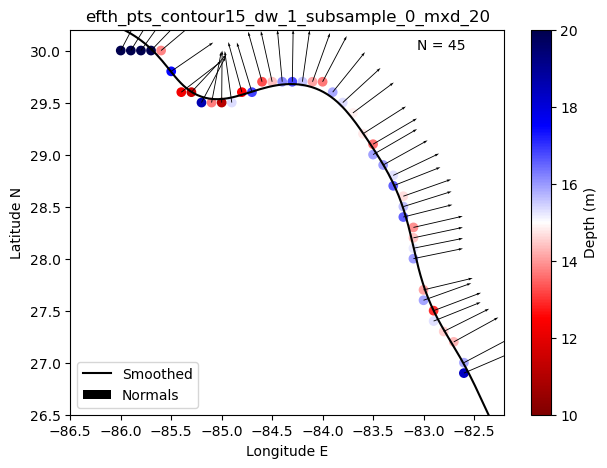

In [22]:
fig, ax = plt.subplots(1,1,figsize=(7,5))
plt.plot(contour15sp[:, 0], contour15sp[:, 1], 'k-', label='Smoothed')  # Longitude vs Latitude

m = plt.scatter( selected_points[:,1], selected_points[:,0], c=selected_points[:,2], cmap='seismic_r', vmin=10., vmax=20.)
plt.quiver(
    selected_points[:, 1], selected_points[:, 0], selected_normals[:, 0], selected_normals[:, 1],
    color='k', angles='xy', scale_units='xy', scale=2, width=.002, label='Normals'
)
plt.colorbar(m, label='Depth (m)')
npts = len(selected_points)
figname = 'efth_pts_contour15_dw_{}_subsample_{}_mxd_{}'.format(depth_weight, spacing_km, mxd)
txt = 'N = {}'.format(npts)
ax.text(.8,.95,txt,transform=ax.transAxes)
plt.ylabel('Latitude N')
plt.xlabel('Longitude E')
plt.xlim(-86.5,-82.2)
plt.ylim(26.5, 30.2)
plt.title(figname)
plt.legend()
plt.savefig( figname+'.png', dpi=200, bbox_inches='tight')

Text(0.5, 0, 'Along-contour distance (km)')

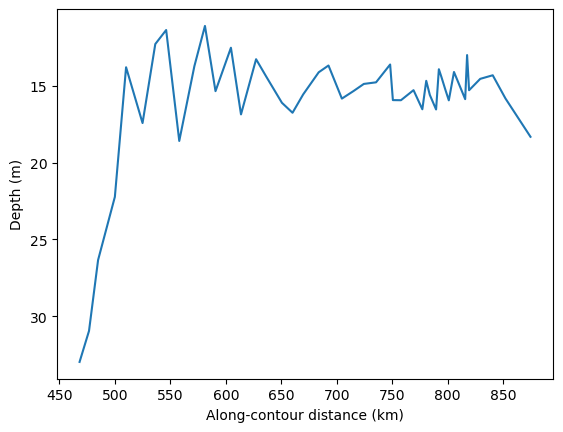

In [23]:
# plot depths v. along-contour distance
fig, ax = plt.subplots()
ax.plot(selected_dist, selected_points[:,2])
ax.invert_yaxis()
plt.ylabel('Depth (m)')
plt.xlabel('Along-contour distance (km)')

In [62]:
rows, cols = np.unravel_index(selected_idx, model_shape)
for i, (r, c) in enumerate(zip(rows, cols)):
    print(f"Flattened index {selected_idx[i]} → 2D index ({r}, {c})")

Flattened index 2805 → 2D index (70, 5)
Flattened index 2806 → 2D index (70, 6)
Flattened index 2807 → 2D index (70, 7)
Flattened index 2808 → 2D index (70, 8)
Flattened index 2809 → 2D index (70, 9)
Flattened index 2730 → 2D index (68, 10)
Flattened index 2651 → 2D index (66, 11)
Flattened index 2652 → 2D index (66, 12)
Flattened index 2613 → 2D index (65, 13)
Flattened index 2614 → 2D index (65, 14)
Flattened index 2615 → 2D index (65, 15)
Flattened index 2616 → 2D index (65, 16)
Flattened index 2657 → 2D index (66, 17)
Flattened index 2658 → 2D index (66, 18)
Flattened index 2699 → 2D index (67, 19)
Flattened index 2700 → 2D index (67, 20)
Flattened index 2701 → 2D index (67, 21)
Flattened index 2702 → 2D index (67, 22)
Flattened index 2703 → 2D index (67, 23)
Flattened index 2704 → 2D index (67, 24)
Flattened index 2705 → 2D index (67, 25)
Flattened index 2666 → 2D index (66, 26)
Flattened index 2627 → 2D index (65, 27)
Flattened index 2588 → 2D index (64, 28)
Flattened index 2509 